## Sarkasmus Klassifikation

In [2]:
#import standard libraries
import collections
import re
import string
import unicodedata
import csv
import random
import json
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

#import nltk libraries
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

#Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Keras
import keras_tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.activations import relu, tanh, sigmoid, linear, gelu
from keras.layers import (Bidirectional, Dense, Dropout, Embedding, GRU, LSTM,
RNN)
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.wrappers.scikit_learn import KerasClassifier



#import sklearn libraries
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
ExtraTreesClassifier, GradientBoostingClassifier,
RandomForestClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, roc_curve,f1_score, precision_score, recall_score
from sklearn.model_selection import KFold,cross_val_score,cross_val_predict,RandomizedSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC, OneClassSVM
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier


#Non-Sklearn libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/flaviopfister/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/p3/w0lx7sbn5pd85k9cmydlynhc0000gn/T/ipykernel_34532/1152891192.py:31: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Preprocessing

In [3]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
#article URLs not needed
df.drop(columns=['article_link'], inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
#display line with most words
print(df['headline'].str.split().apply(len).sort_values(ascending=False).head(2))
#delete headlines with more than 40 words
df = df[df['headline'].str.split().apply(len) < 40]
#remove Stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

print(df['headline'].str.split().apply(len).sort_values(ascending=False).head(2))
#applay length of longest headline a variable
max_len = df['headline'].str.split().apply(len).sort_values(ascending=False).head(1).values[0]

7302     151
24815     39
Name: headline, dtype: int64
24815    39
23598    38
Name: headline, dtype: int64


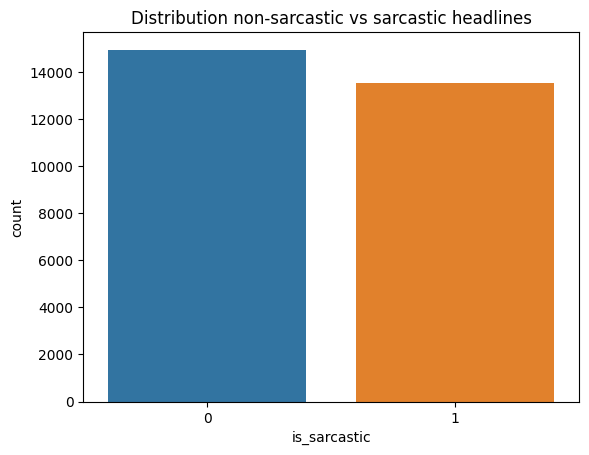

In [20]:
#Plot of the distribution of the is_sarcastic column
sns.countplot(x='is_sarcastic', data=df)
plt.title('Distribution non-sarcastic vs sarcastic headlines')
plt.show()


In [8]:
df.head()
#get number of diffrent words in headlines
words = []
for headline in df['headline']:
    for word in headline.split():
        words.append(word)
print(len(set(words)))


38212


In [9]:
#kudos https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy#LOADING-THE-DATASET
#remove square brackets, URLs and Noise

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing numbers as it can cause additional noise
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

#Removing the noisy text 
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

/Users/flaviopfister/anaconda3/envs/NLP/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [10]:
#converting text to format acceptable by gensim

words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

# copy Dataset for ML 

In [11]:
#create a copy of the dataframe
df_ml = df.copy()
#train test split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(df_ml['headline'], df_ml['is_sarcastic'], test_size=0.25, random_state=42)
#validation
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(X_train_ml, y_train_ml, test_size=0.2, random_state=42)


# TFIDVectorizer

In [12]:
#https://www.kaggle.com/code/eisgandar/sarcastic-headlines-detector-lstm
#diffrent vectorizers
tf_idf_word_vectorizer = TfidfVectorizer(analyzer = "word")
tf_idf_word_vectorizer.fit(X_train_ml)

x_train_vec = tf_idf_word_vectorizer.transform(X_train_ml)
x_val_vec = tf_idf_word_vectorizer.transform(X_val_ml)
x_test_vec = tf_idf_word_vectorizer.transform(X_test_ml)

#x_train_vec.toarray()

print(x_train_vec.shape)
print(x_val_vec.shape)
print(x_test_vec.shape)


(17100, 20490)
(4276, 20490)
(7126, 20490)


# Binary CountVectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

C_vectorizer = CountVectorizer(binary=True)

# Fit the vectorizer to the training data and transform both train and test data
X_train_binary = C_vectorizer.fit_transform(X_train_ml).astype('float32')
X_val_binary = C_vectorizer.transform(X_val_ml).astype('float32')
X_test_binary = C_vectorizer.transform(X_test_ml).astype('float32')

#The main advantage of using the binary vectorizer over the TF vectorizer is that it reduces the impact of features that occur frequently in the dataset

# Hashing

In [14]:
# Define the vectorizers
from sklearn.feature_extraction.text import HashingVectorizer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

hashing_vectorizer = HashingVectorizer(binary=True)

# Vectorize the data
train_x_hashing = hashing_vectorizer.transform(X_train_ml)
valid_x_hashing = hashing_vectorizer.transform(X_val_ml)
test_x_hashing = hashing_vectorizer.transform(X_test_ml)

## Word2Vec Model

In [15]:

#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words, window = 5, min_count = 1)
w2v_model.wv.vectors.shape

(37034, 100)

In [16]:
tokenizer = text.Tokenizer(num_words=40000)
tokenizer.fit_on_texts(words)
#tokenized_train = tokenizer.texts_to_sequences(words)
#x = sequence.pad_sequences(tokenized_train, maxlen = 20)
sequences = tokenizer.texts_to_sequences(words)
#max_len changed to the longest headline
padded_sequences = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
padded_sequences

array([[    0,     0,     0, ...,  2307,   552,   930],
       [    0,     0,     0, ..., 11228,  1972,  1787],
       [    0,     0,     0, ..., 16405,   471,  1339],
       ...,
       [    0,     0,     0, ...,   942,   662,  1633],
       [    0,     0,     0, ..., 37034,   811,  5884],
       [    0,     0,     0, ...,  2940,   171,    92]], dtype=int32)

In [18]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [19]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


### Training Word2Vec model

In [20]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df.is_sarcastic , test_size = 0.2 , random_state = 187) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25 , random_state = 187)

In [21]:

# Define the model architecture
# Refactoring of Dennis Code with CHATGPT
def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], trainable=True))

    prev_units = hp.Int("prev_units", min_value=8, max_value=96, step=2, default=96)

    for i in range(hp.Int("num_layers", 1, 3)):
        for layer_type in [LSTM, GRU]:
            curr_units = hp.Int(f"units_{i}", min_value=8, max_value=prev_units, step=2)
            prev_units = curr_units

            model.add(Bidirectional(layer_type(units=curr_units,
                                               recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.9, step=0.1),
                                               dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.9, step=0.1),
                                               activation=hp.Choice(f"activation_{i}", values=["relu", "tanh", "gelu"]),
                                               return_sequences=True),
                                               name=f"bidirectional_{layer_type.__name__.lower()}_{i}"))

    learning_rate_tuned = hp.Float("lr", min_value=1e-4, max_value=1e-3, sampling="log")

    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tuned),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    return model



In [22]:
#helper class so callback works with tuner (ChatGPT)
class TerminationOnNoImprovement(keras.callbacks.Callback):
    def __init__(self, patience=10, restore_best_weights=True):
        super(TerminationOnNoImprovement, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_epoch = None
        self.best_val_acc = None

    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()
        self.best_epoch = 0
        self.best_val_acc = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc > self.best_val_acc:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
            self.best_val_acc = val_acc
        elif epoch - self.best_epoch >= self.patience:
            print(f'Epoch {epoch}: early stopping')
            self.model.stop_training = True
            if self.restore_best_weights:
                print(f'Restored model weights from epoch {self.best_epoch}')
                self.model.set_weights(self.best_weights)




In [23]:
from keras.utils import plot_model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='Tuner',
    project_name='NLP_Tuner',
    seed=187
)
'''
batch_sizes = [16,32, 64, 128, 256,512,1024,2048]


best_batch_size = None; best_model = None; best_hparams = None; best_val_acc = -float('inf')

for _ in range(len(batch_sizes)):
    #batch_size = random.choice(batch_sizes)
    #print(f'Batch size: {batch_size}')
    tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=128, callbacks=[TerminationOnNoImprovement()])
    trial_best_model = tuner.get_best_models(num_models=1)[0]
    trial_best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]
    trial_best_val_acc = tuner.get_best_trial('val_accuracy').score

    if trial_best_val_acc > best_val_acc:
        best_batch_size = 128
        best_model = trial_best_model
        best_hparams = trial_best_hparams
        best_val_acc = trial_best_val_acc
        #plot model
        plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)
        #write best model to file
        best_model.save('best_model.h5')
        #write best hyperparameters to file
        with open('best_hparams.json', 'w') as f:
            json.dump(best_hparams.values, f)

#Batch_size manually written
print(f'Best batch size: 128')
print(f'Best validation accuracy: {best_val_acc}')
print(f'Best hyperparameters: {best_hparams.values}')
'''



INFO:tensorflow:Reloading Tuner from Tuner/NLP_Tuner/tuner0.json


"\nbatch_sizes = [16,32, 64, 128, 256,512,1024,2048]\n\n\nbest_batch_size = None; best_model = None; best_hparams = None; best_val_acc = -float('inf')\n\nfor _ in range(len(batch_sizes)):\n    #batch_size = random.choice(batch_sizes)\n    #print(f'Batch size: {batch_size}')\n    tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=128, callbacks=[TerminationOnNoImprovement()])\n    trial_best_model = tuner.get_best_models(num_models=1)[0]\n    trial_best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]\n    trial_best_val_acc = tuner.get_best_trial('val_accuracy').score\n\n    if trial_best_val_acc > best_val_acc:\n        best_batch_size = 128\n        best_model = trial_best_model\n        best_hparams = trial_best_hparams\n        best_val_acc = trial_best_val_acc\n        #plot model\n        plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)\n        #write best model to file\n        best_model.save('

In [24]:
#get the best models
best_model = tuner.get_best_models(num_models=1)[0]
best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]
#get summary of best model
best_model.summary()
#plot model
plot_model(best_model, to_file='best_model.png', show_shapes=True, show_layer_names=True)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3703500   
                                                                 
 bidirectional_lstm_0 (Bidir  (None, None, 100)        60400     
 ectional)                                                       
                                                                 
 bidirectional_gru_0 (Bidire  (None, None, 100)        45600     
 ctional)                                                        
                                                                 
 bidirectional_lstm_1 (Bidir  (None, None, 16)         6976      
 ectional)                                                       
                                                                 
 bidirectional_gru_1 (Bidire  (None, None, 16)         1248      
 ctional)                                               

In [25]:
#show the best hyperparameters, wirte each value seperately
print(f'Best hyperparameters: {best_hparams.values}')

Best hyperparameters: {'prev_units': 38, 'num_layers': 3, 'units_0': 50, 'recurrent_dropout_0': 0.0, 'dropout_0': 0.6000000000000001, 'activation_0': 'tanh', 'lr': 0.0003645799298848718, 'units_1': 8, 'recurrent_dropout_1': 0.0, 'dropout_1': 0.0, 'activation_1': 'relu', 'units_2': 8, 'recurrent_dropout_2': 0.0, 'dropout_2': 0.0, 'activation_2': 'relu'}


In [26]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Flatten
from tensorflow.keras.models import Sequential
#best model after 20 first trials
#best val_accuracy 80.08%
#{'prev_units': 38,
# 'num_layers': 3,
# 'units_0': 50,
# 'recurrent_dropout_0': 0.0,
# 'dropout_0': 0.6000000000000001,
# 'activation_0': 'tanh',
# 'lr': 0.0003645799298848718, 
# 'units_1': 8,
# 'recurrent_dropout_1': 0.0,
# 'dropout_1': 0.0,
# 'activation_1': 'relu',
# 'units_2': 8,
# 'recurrent_dropout_2': 0.0,
# 'dropout_2': 0.0,
# 'activation_2': 'relu'}


# Defining Neural Network
model = Sequential()

# Non-trainable embedding layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], trainable=True))

# LSTM 
model.add(Bidirectional(LSTM(units=50, activation='tanh', recurrent_dropout=0.0, dropout=0.6, return_sequences=True)))
model.add(Bidirectional(GRU(units=50, activation='tanh', recurrent_dropout=0.0, dropout=0.6, return_sequences=True)))

model.add(Bidirectional(LSTM(units= 8, activation='relu', recurrent_dropout=0.0, dropout=0.0, return_sequences=True)))
model.add(Bidirectional(GRU(units= 8, activation='relu', recurrent_dropout=0.0, dropout=0.0, return_sequences=True)))

model.add(Bidirectional(LSTM(units=8, activation='relu', recurrent_dropout=0.0, dropout=0.0, return_sequences=True)))
model.add(Bidirectional(GRU(units=8, activation='relu', recurrent_dropout=0.0, dropout=0.0, return_sequences=True)))

# Output layer
model.add(Dense(1, activation='tanh'))
#model.add(Flatten())  # Convert 2D tensor to 1D tensor
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003645799298848718), loss='binary_crossentropy', metrics=['acc'])



In [27]:

#early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_val,y_val) , epochs = 1000, callbacks=[early_stopping])



Epoch 1/1000


2023-04-21 14:38:51.079060: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


134/134 [==============================] - 26s 132ms/step - loss: 0.8476 - acc: 0.5457 - val_loss: 0.6843 - val_acc: 0.5699
Epoch 2/1000
134/134 [==============================] - 21s 155ms/step - loss: 0.6736 - acc: 0.5845 - val_loss: 0.6714 - val_acc: 0.5950
Epoch 3/1000
134/134 [==============================] - 21s 160ms/step - loss: 0.5470 - acc: 0.7178 - val_loss: 0.4478 - val_acc: 0.7914
Epoch 4/1000
134/134 [==============================] - 24s 176ms/step - loss: 0.2936 - acc: 0.8771 - val_loss: 0.4516 - val_acc: 0.8076
Epoch 5/1000
134/134 [==============================] - 24s 180ms/step - loss: 0.1866 - acc: 0.9257 - val_loss: 0.4686 - val_acc: 0.8034
Epoch 6/1000
134/134 [==============================] - 24s 177ms/step - loss: 0.1289 - acc: 0.9518 - val_loss: 0.5314 - val_acc: 0.7903
Epoch 7/1000
134/134 [==============================] - 24s 178ms/step - loss: 0.1000 - acc: 0.9617 - val_loss: 0.6442 - val_acc: 0.7920
Epoch 8/1000
134/134 [==============================] 

In [28]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)
print("Accuracy of the model on Validation Data is - " , model.evaluate(x_val,y_val)[1]*100)

535/535 [==============================] - 8s 16ms/step - loss: 0.0206 - acc: 0.9928
Accuracy of the model on Training Data is -  99.27993416786194
179/179 [==============================] - 3s 16ms/step - loss: 1.3662 - acc: 0.7701
Accuracy of the model on Testing Data is -  77.0071804523468
179/179 [==============================] - 3s 15ms/step - loss: 1.4471 - acc: 0.7622
Accuracy of the model on Validation Data is -  76.21919512748718


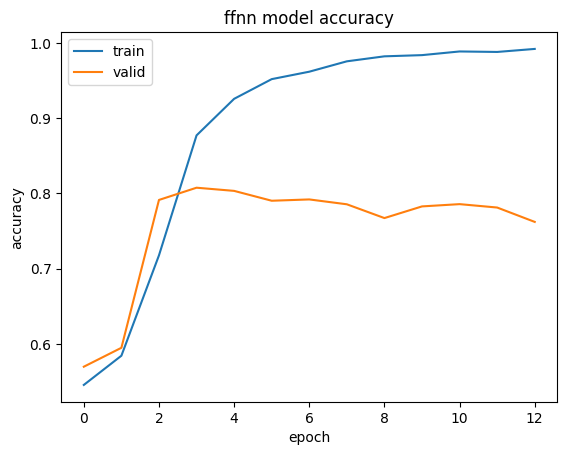

In [29]:
#plot accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ffnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


## Machine Learning

In [30]:
def evaluate_models(x_train_vec, y_train_ml, x_val_vec, y_val_ml, x_test_vec, y_test_ml):
    # Define the models to be compared
    models = [

        ('Ridge Classifier', RidgeClassifier(random_state=187)),
        ('Multinomial Naive Bayes', MultinomialNB()),
        ('Bernoulli Naive Bayes', BernoulliNB()),
        ('Logistic Regression', LogisticRegression(random_state=187, max_iter=10000,n_jobs=-1)),
        ('Decision Tree', DecisionTreeClassifier(random_state=187)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=187)),
        ('XGBoost', XGBClassifier(random_state=187,n_jobs=-1)),
        ('LightGBM', LGBMClassifier(random_state=187,n_jobs=-1)),
        ('SVM', SVC(kernel='rbf',random_state=187)),
        ('LinearSVC', LinearSVC(random_state=187)),
        ('ExtraTrees', ExtraTreesClassifier(random_state=187,n_jobs=-1)),
        ('PassiveAggressive', PassiveAggressiveClassifier(random_state=187, n_jobs=-1))
        
    ]

    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Model', 'Train Score', 'Validation Score', 'Test Score'])

    # Evaluate the models using 5-fold cross-validation
    kfold = KFold(n_splits=5, random_state=187, shuffle=True)
    for name, model in models:
        cv_results = cross_val_score(model, x_train_vec, y_train_ml, cv=kfold, scoring='accuracy', n_jobs=-1)
        train_score = cv_results.mean()
        validation_score = model.fit(x_train_vec, y_train_ml).score(x_val_vec, y_val_ml)
        test_score = model.fit(x_train_vec, y_train_ml).score(x_test_vec, y_test_ml)
        #predict
        y_pred = model.predict(x_val_vec)
        #print classification report
        print(classification_report(y_val_ml, y_pred))
        results_df = pd.concat([results_df, pd.DataFrame([[name, train_score, validation_score, test_score]],
                                                          columns=['Model', 'Train Score', 'Validation Score', 'Test Score'])],
                               ignore_index=True)
        print(f"{name}: Train Score: {train_score:.2f}, Validation Score: {validation_score:.2f}, Test Score: {test_score:.2f}")

    # Return the results dataframe
    return results_df


In [35]:
result_count= evaluate_models(X_train_binary, y_train_ml, X_val_binary, y_val_ml, X_test_binary, y_test_ml)

result_TFID= evaluate_models(x_train_vec, y_train_ml, x_val_vec, y_val_ml, x_test_vec, y_test_ml)

result_hash = evaluate_models(train_x_hashing, y_train_ml, valid_x_hashing, y_val_ml, test_x_hashing, y_test_ml)

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      2266
           1       0.76      0.71      0.73      2010

    accuracy                           0.76      4276
   macro avg       0.76      0.76      0.76      4276
weighted avg       0.76      0.76      0.76      4276

Ridge Classifier: Train Score: 0.76, Validation Score: 0.76, Test Score: 0.76
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2266
           1       0.78      0.78      0.78      2010

    accuracy                           0.79      4276
   macro avg       0.79      0.79      0.79      4276
weighted avg       0.79      0.79      0.79      4276

Multinomial Naive Bayes: Train Score: 0.79, Validation Score: 0.79, Test Score: 0.79
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2266
           1       0.82      0.73      0.77      2010

    accuracy       

/Users/flaviopfister/anaconda3/envs/NLP/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.74      0.70      0.72      2266
           1       0.68      0.72      0.70      2010

    accuracy                           0.71      4276
   macro avg       0.71      0.71      0.71      4276
weighted avg       0.71      0.71      0.71      4276

Decision Tree: Train Score: 0.72, Validation Score: 0.71, Test Score: 0.71
              precision    recall  f1-score   support

           0       0.63      0.92      0.75      2266
           1       0.82      0.39      0.53      2010

    accuracy                           0.67      4276
   macro avg       0.72      0.66      0.64      4276
weighted avg       0.72      0.67      0.64      4276

Gradient Boosting: Train Score: 0.67, Validation Score: 0.67, Test Score: 0.67
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      2266
           1       0.80      0.59      0.68      2010

    accuracy                

In [37]:
def plot_model_scores(results_df, title):
    # Sort results dataframe by test score
    results_df = results_df.sort_values(by='Test Score', ascending=False)

    # Plot bar chart of model scores
    results_df.plot(x='Model', y=['Train Score', 'Validation Score', 'Test Score'], kind='bar', figsize=(15, 5), title=title)
    plt.ylim(0.5, 1)
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.grid(axis='y')
    plt.grid(axis='x')
    plt.ylabel('Accuracy')
    plt.show()


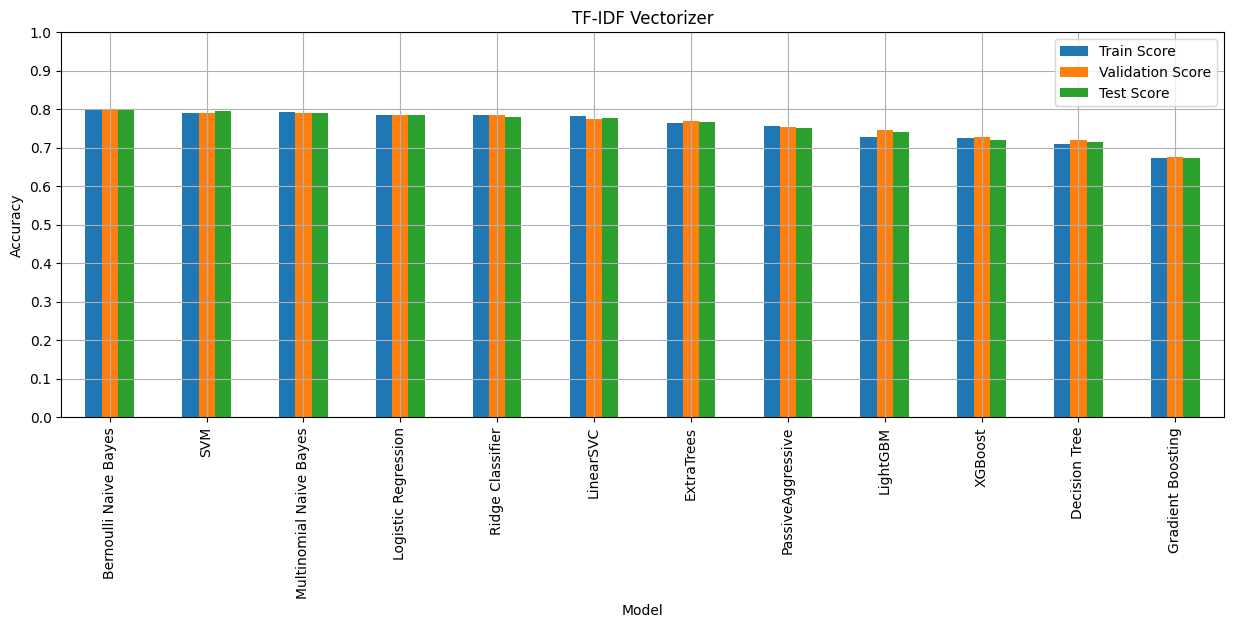

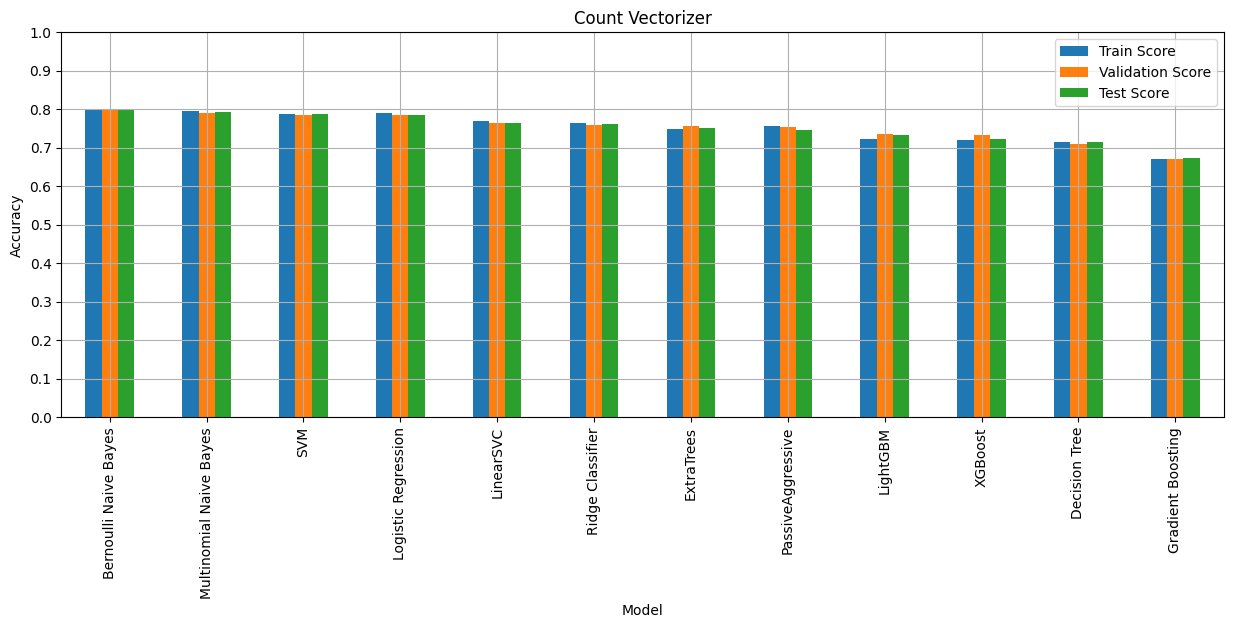

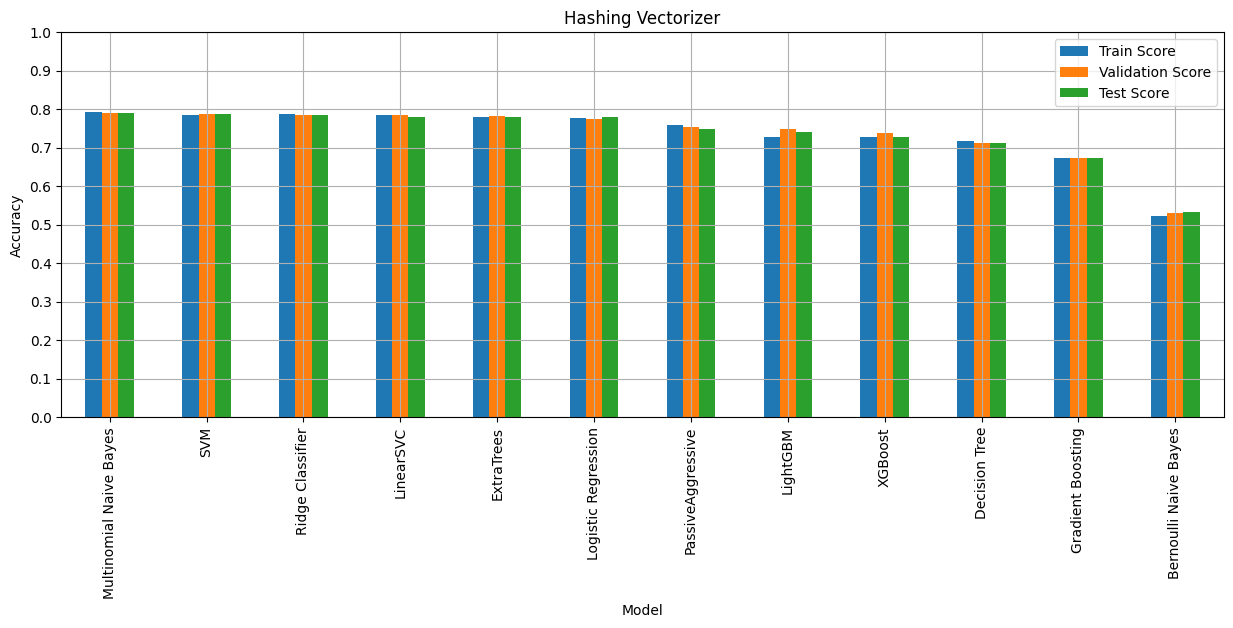

In [38]:
plot_model_scores(result_TFID, 'TF-IDF Vectorizer')
plot_model_scores(result_count, 'Count Vectorizer')
plot_model_scores(result_hash, 'Hashing Vectorizer')

In [32]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB


param_dist = {
    #alpha is the smoothing parameter
    'alpha': np.arange(0.1, 1.1, 0.001),
    #binarize is the threshold for binarizing (mapping to booleans) of sample features
    'binarize': np.arange(0.1, 1.1, 0.001),
    #fit_prior is whether to learn class prior probabilities or not
    'fit_prior': [True,False],
    #class_prior is the prior probabilities of the classes
    'class_prior': [None, [0.5, 0.5], [0.25, 0.75], [0.75, 0.25], [0.1, 0.9],
                    [0.9, 0.1], [0.2, 0.8], [0.8, 0.2], [0.3, 0.7], [0.7, 0.3]]
}

model = BernoulliNB()

random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_dist, 
    n_iter=100000, 
    cv=5, 
    scoring='accuracy', 
    random_state=187,
    error_score=np.nan,
    n_jobs=-1
)

random_search.fit(X_train_binary, y_train_ml)

print("Best params: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)


Best params:  {'fit_prior': False, 'class_prior': None, 'binarize': 0.9020000000000007, 'alpha': 0.6870000000000005}
Best score:  0.8041520467836257


              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2266
           1       0.80      0.76      0.78      2010

    accuracy                           0.80      4276
   macro avg       0.80      0.80      0.80      4276
weighted avg       0.80      0.80      0.80      4276



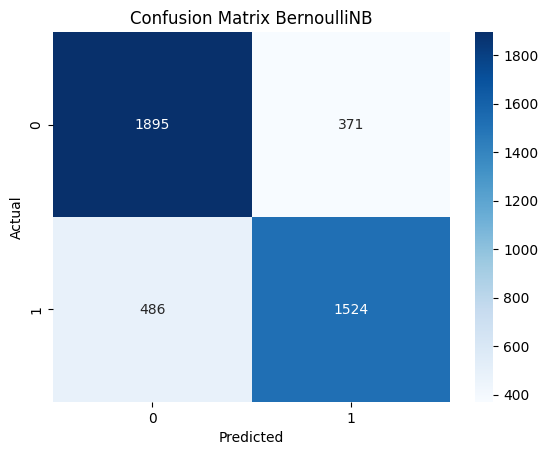

In [39]:
#model with best params
model = BernoulliNB(fit_prior= False, class_prior= None, binarize= 0.9020000000000007, alpha = 0.6870000000000005)
model.fit(X_train_binary, y_train_ml)
y_pred = model.predict(X_val_binary)
print(classification_report(y_val_ml, y_pred))

#visual representation of confusion matrix

cm = confusion_matrix(y_val_ml, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix BernoulliNB')
plt.show()


In [34]:
feature_names = C_vectorizer.get_feature_names_out()

# Get the log probabilities for each feature given each class
log_probs = model.feature_log_prob_

# Sort the log probabilities by class and by feature
sorted_log_probs = np.argsort(log_probs, axis=1)

# Print the top 5 words for each class
n_top_words = 10
for i in range(model.classes_.size):
    class_name = model.classes_[i]
    print(f'Top {n_top_words} words for class {class_name}:')
    for j in sorted_log_probs[i, :n_top_words]:
        print(f'{feature_names[j]}: {log_probs[i, j]:.3f}')
    print()

Top 10 words for class 0:
aaa: -9.470
lexicon: -9.470
lhabab: -9.470
liability: -9.470
libations: -9.470
libbing: -9.470
libby: -9.470
liberace: -9.470
lewinsky: -9.470
liberates: -9.470

Top 10 words for class 1:
laverne: -9.387
egypt: -9.387
egregious: -9.387
egos: -9.387
productions: -9.387
egidio: -9.387
professes: -9.387
efron: -9.387
efforts: -9.387
effortless: -9.387

